# Questão do negócio
**Contexto geral** - A empresa X-Health atua no comércio B2B vendendo dispositivos eletrônicos voltados para saúde com amplo espectro de preços, e de variada sofisticação/complexidade.

**Sobre as vendas** - As vendas são feitas à crédito: o cliente B2B faz seu pedido e paga (à vista ou em várias parcelas, conforme o combinado pelo time de vendas) num tempo futuro pré-determinado.

**O problema** - O time financeiro da X-Health tem observado um número indesejável de não-pagamentos ("default" ou calote, em bom português).

**O objetivo** - Querem de alguma forma minimizar esse fenômeno. Desejam uma solução capaz de identificar os clientes podem vir o dar o default (ou "calote").

Antes de iniciar a solução, é fundamental estabelecer premissas que ajudarão a moldar sua abordagem. Isso inclui:

Compreensão do Negócio: Entender profundamente o contexto no qual a X-Health opera, incluindo o perfil de seus clientes B2B, e como os processos de crédito e pagamento impactam a operação.

Limitações e Desafios de Dados: Identificar quaisquer limitações nos dados fornecidos, como a representatividade, viés, ou qualidade dos dados. Considerar como esses fatores podem afetar a modelagem e a interpretação dos resultados.

Aspectos Éticos e Regulatórios: Considerar quaisquer implicações éticas e regulatórias associadas ao uso de dados de crédito e pessoais, especialmente em relação à privacidade e discriminação.

Impacto do Modelo: Refletir sobre como a implementação do modelo pode impactar a empresa e seus clientes. Isso inclui considerar tanto os benefícios potenciais quanto os riscos associados.

# 0.0 Imports

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score



warnings.filterwarnings( 'ignore' )
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
df_raw = pd.read_csv('data/dataset.csv', sep='\t', encoding='utf-8')

# 1.0 Descrição dos Dados

In [3]:
df = df_raw.copy()

## 1.1 Data Dimensions

In [4]:
print('Number of Rows: {}'.format(df.shape[0]))
print('Number of Cols: {}'.format(df.shape[1]))

Number of Rows: 117273
Number of Cols: 22


## 1.2 Data Types

In [5]:
df.dtypes

default_3months                  int64
ioi_36months                   float64
ioi_3months                    float64
valor_por_vencer               float64
valor_vencido                  float64
valor_quitado                  float64
quant_protestos                  int64
valor_protestos                float64
quant_acao_judicial              int64
acao_judicial_valor            float64
participacao_falencia_valor    float64
dividas_vencidas_valor         float64
dividas_vencidas_qtd             int64
falencia_concordata_qtd          int64
tipo_sociedade                  object
opcao_tributaria                object
atividade_principal             object
forma_pagamento                 object
valor_total_pedido             float64
month                            int64
year                             int64
default                          int64
dtype: object

## 1.3 Check NA's
- Valores faltantes estão indicados no dataset como "missing".

In [6]:
# substituindo os valores "missing" por "NA"
df.replace('missing', pd.NA, inplace=True)

# visualizando os valores faltantes
df.isna().sum()

default_3months                    0
ioi_36months                       0
ioi_3months                        0
valor_por_vencer                   0
valor_vencido                      0
valor_quitado                      0
quant_protestos                    0
valor_protestos                    0
quant_acao_judicial                0
acao_judicial_valor                0
participacao_falencia_valor        0
dividas_vencidas_valor             0
dividas_vencidas_qtd               0
falencia_concordata_qtd            0
tipo_sociedade                   608
opcao_tributaria               18325
atividade_principal              592
forma_pagamento                32477
valor_total_pedido                 0
month                              0
year                               0
default                            0
dtype: int64

### 1.3.1 Tratando os NA's

In [7]:
# forma_pagamento: assumir valores faltantes como '30/60/90'
valor_forma_pagamento = '30/60/90'
df['forma_pagamento'] = df['forma_pagamento'].fillna(valor_forma_pagamento)

# atividade_principal: assumir valores faltantes como 'atividade não informada'
valor_atividade = 'atividade não informada'
df['atividade_principal'] = df['atividade_principal'].fillna(valor_atividade)

# opcao_tributaria: assumir valores faltantes como 'opção tributaria não informada'
valor_OT = 'opção tributaria não informada'
df['opcao_tributaria'] = df['opcao_tributaria'].fillna(valor_OT)

# tipo_sociedade: assumir valores faltantes como 'tipo de sociedade não informada'
valor_sociedade_n = 'tipo de sociedade não informada'
df['tipo_sociedade'] = df['tipo_sociedade'].fillna(valor_sociedade_n)

## 1.4 Estatística Descritiva dos Dados

In [8]:
df.describe()

,default_3months,ioi_36months,ioi_3months,valor_por_vencer,valor_vencido,valor_quitado,quant_protestos,valor_protestos,quant_acao_judicial,acao_judicial_valor,participacao_falencia_valor,dividas_vencidas_valor,dividas_vencidas_qtd,falencia_concordata_qtd,valor_total_pedido,month,year,default
count,117273.00,117273.00,117273.00,117273.00,117273.00,117273.00,117273.00,117273.00,117273.00,117273.00,117273.00,117273.00,117273.00,117273.00,117273.00,117273.00,117273.00,117273.00
mean,0.15,55.58,17.11,64213.84,2454.04,1085557.34,0.24,2051.02,0.02,921.85,0.00,560.38,0.01,0.00,24061.80,6.28,2017.98,0.17
std,0.85,60.99,10.99,525254.63,80933.13,7444825.41,10.71,88317.58,0.53,48610.25,0.00,84592.91,0.40,0.03,490667.96,3.19,0.74,0.37
min,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-744.69,1.00,2017.00,0.00
25%,0.00,20.17,11.12,565.74,0.00,19442.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2140.42,3.00,2017.00,0.00
50%,0.00,38.00,16.00,4451.74,0.00,81348.78,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4012.73,7.00,2018.00,0.00
75%,0.00,69.75,18.25,20062.96,0.00,332264.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9645.92,9.00,2019.00,0.00
max,26.00,951.00,90.00,72197586.36,13150500.00,460320322.80,2324.00,16305457.00,80.00,8390986.00,0.00,19722514.00,40.00,2.00,150333994.61,12.00,2019.00,1.00


# 2.0 Feature Engineering

In [9]:
df1 = df.copy()

## 2.1 Tratamento das variáveis de data

In [10]:
# unindo as colunas 'month' e 'year' e atribuindo ao datetime
df1['data'] = pd.to_datetime(df1['year'].astype(str) + '-' + df1['month'].astype(str) + '-01')

# excluindo as colunas antigas
df1 = df1.drop(columns=['month', 'year'])

## 2.2 Categorização das variavéis de valores

In [11]:
# Criando faixa de valores para variáveis para utilizarmos no modelo preditivo

# valor_vencido
bins = [1, 5000, 10000, 20000, 50000, 100000, 500000, 1000000, 9000000000]
labels = ['Até 5 mil', '6 até 10 mil', '11 até 20 mil', '21 até 50 mil', '51 até 100 mil', '101 até 500 mil',
          '500 até 1 milhão', 'Mais de 1 milhão']
df1['faixa_valor_vencido'] = pd.cut(df1['valor_vencido'], bins=bins, labels=labels)

# valor_protestos
bins = [1, 5000, 10000, 30000, 60000, 100000, 500000, 1000000, 9000000000]
labels = ['Até 5 mil', '6 até 10 mil', '11 até 30 mil', '31 até 60 mil', '61 até 100 mil', '101 até 500 mil',
          '500 até 1 milhão', 'Mais de 1 milhão']
df1['faixa_valor_protestos'] = pd.cut(df1['valor_protestos'], bins=bins, labels=labels)

# acao_judicial_valor
bins = [1, 5000, 10000, 30000, 60000, 100000, 500000, 1000000, 9000000000]
labels = ['Até 5 mil', '6 até 10 mil', '11 até 30 mil', '31 até 60 mil', '61 até 100 mil', '101 até 500 mil',
          '500 até 1 milhão', 'Mais de 1 milhão']
df1['faixa_valor_acao_judicial'] = pd.cut(df1['acao_judicial_valor'], bins=bins, labels=labels)

# dividas_vencidas_valor
bins = [1, 2500, 5000, 10000, 30000, 60000, 100000, 500000, 9000000000]
labels = ['Até 2,5 mil', '2,6 até 5 mil', '6 até 10 mil', '11 até 30 mil', '31 até 60 mil', '60 até 100 mil',
          '101 até 500 mil', 'Mais de 500 mil']
df1['faixa_valor_dividas_vencidas'] = pd.cut(df1['dividas_vencidas_valor'], bins=bins, labels=labels)
pd.value_counts(df1['faixa_valor_dividas_vencidas'])

# valor_total_pedido
bins = [1, 5000, 10000, 30000, 100000, 500000, 1000000, 9000000000]
labels = ['Até 5 mil', '6 até 10 mil', '11 até 30 mil', '31 até 100 mil', '101 até 500 mil', '500 até 1 milhão',
          'Mais de 1 milhão']
df1['faixa_valor_total_pedido'] = pd.cut(df1['valor_total_pedido'], bins=bins, labels=labels)

## 2.3 Selecionando as novas colunas

In [12]:
df1.columns

columns = ['default_3months', 'ioi_36months', 'ioi_3months', 'valor_por_vencer',
           'valor_quitado', 'quant_protestos', 'quant_acao_judicial', 'participacao_falencia_valor', 
           'dividas_vencidas_qtd', 'falencia_concordata_qtd', 'tipo_sociedade', 'opcao_tributaria', 
           'atividade_principal', 'forma_pagamento', 'default', 'data', 'faixa_valor_vencido',
           'faixa_valor_protestos', 'faixa_valor_acao_judicial', 'faixa_valor_dividas_vencidas', 'faixa_valor_total_pedido']

df2 = pd.DataFrame(df1, columns=columns)

# 3.0 Análise Exploratória

## 3.1 Análise Univariada

### 3.1.1 Variável resposta

<Axes: xlabel='default', ylabel='count'>

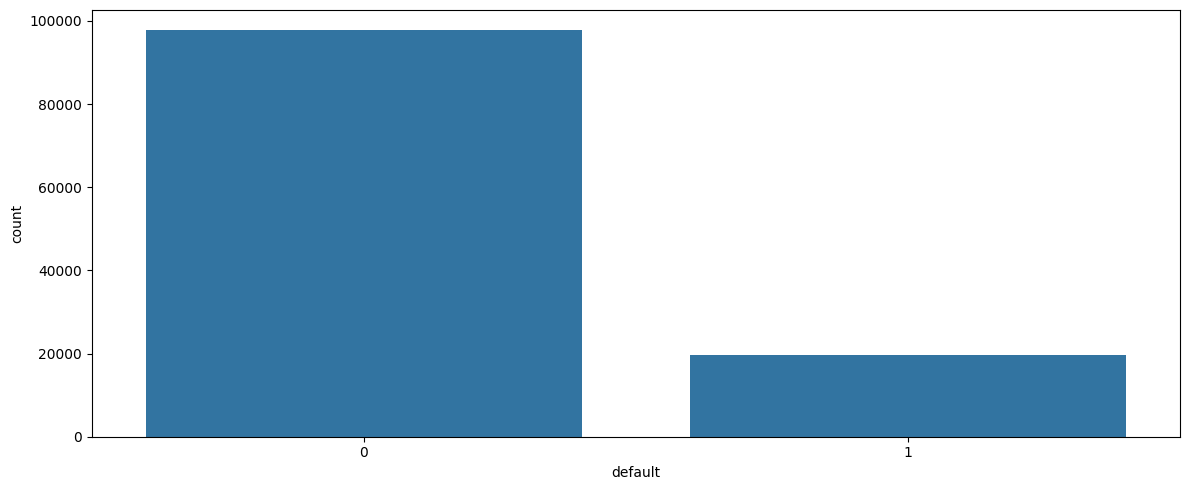

In [42]:
# plot para visualizar o número de pagamentos realizados(0) e pagamentos não realizados(1)
sns.countplot(data=df2, x='default')

### 3.1.2 Faixa de valores vencidos

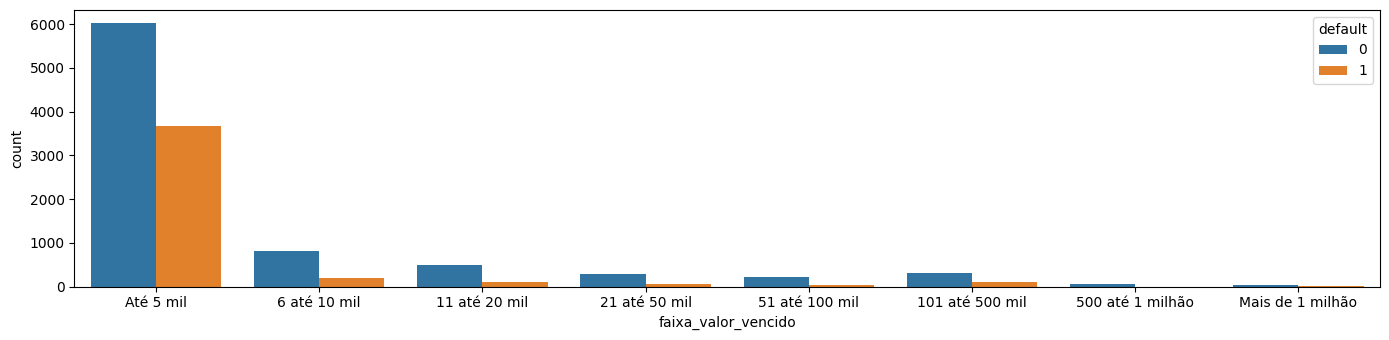

In [14]:
plt.rcParams['figure.figsize'] = [14.00, 3.50]
plt.rcParams['figure.autolayout'] = True
sns.countplot(data=df2, x= 'faixa_valor_vencido', hue= 'default')
plt.show()

### 3.1.3 Faixa de valores dos pedidos

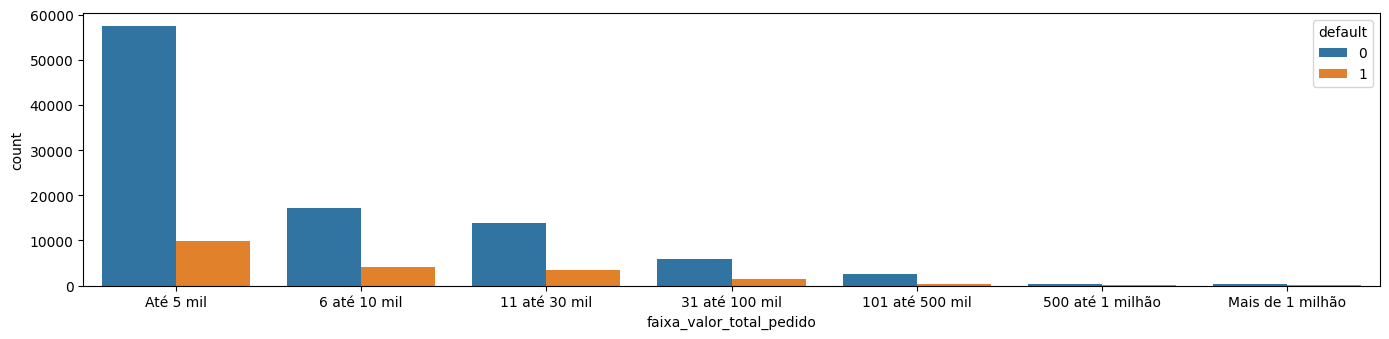

In [15]:
plt.rcParams['figure.figsize'] = [14.00, 3.50]
plt.rcParams['figure.autolayout'] = True
sns.countplot(data=df2, x= 'faixa_valor_total_pedido', hue= 'default')
plt.show()

### 3.1.4 Faixa de valores protestos

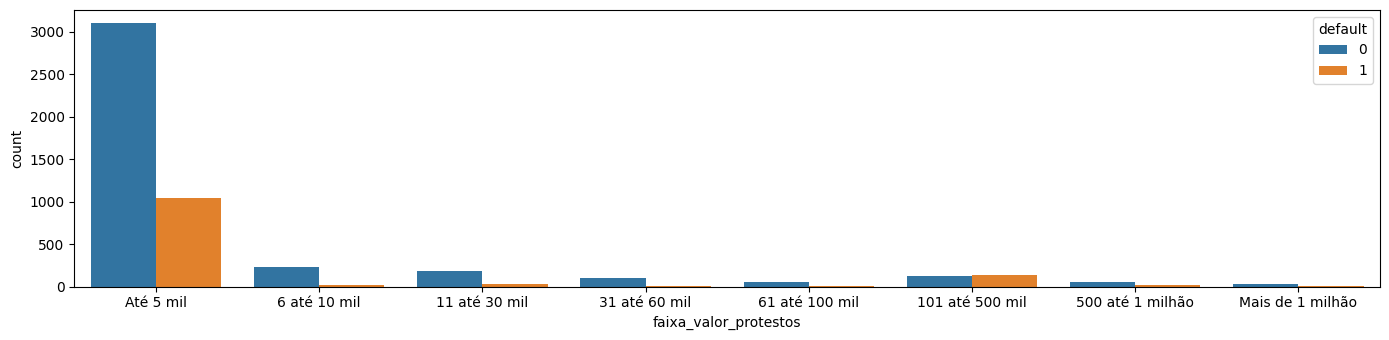

In [16]:
plt.rcParams['figure.autolayout'] = True
sns.countplot(data=df2, x= 'faixa_valor_protestos', hue= 'default')
plt.show()

### 3.1.5 Faixa de valores em ação judicial

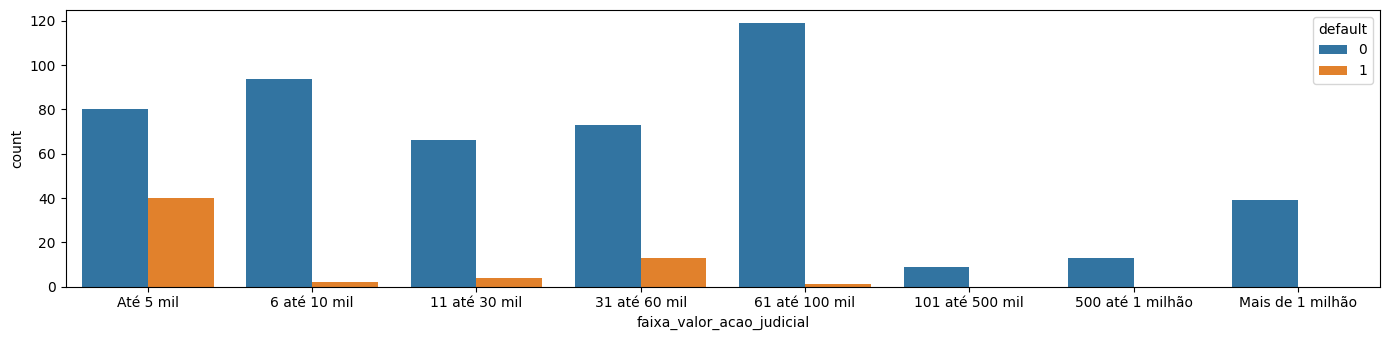

In [17]:
plt.rcParams['figure.figsize'] = [14.00, 3.50]
plt.rcParams['figure.autolayout'] = True
sns.countplot(data=df2, x= 'faixa_valor_acao_judicial', hue= 'default')
plt.show()

### 3.1.6 Faixa de valores de dividas vencidas

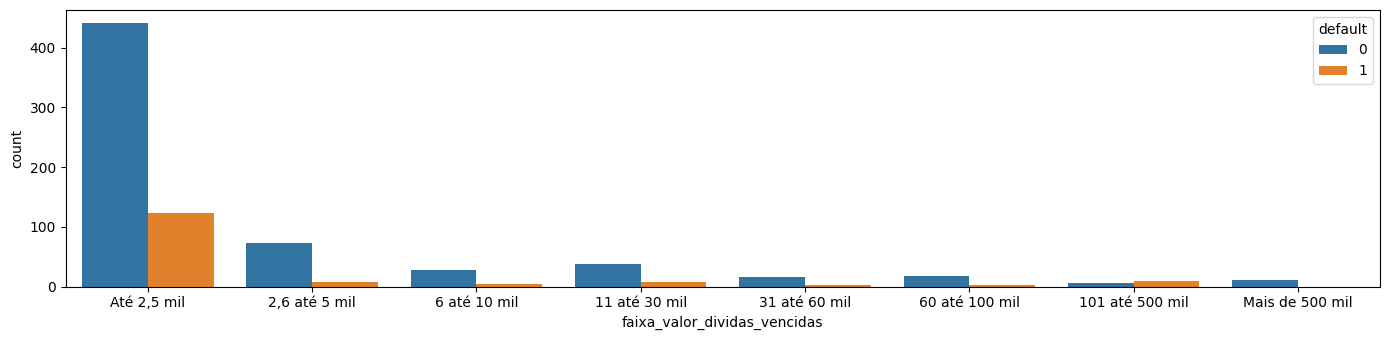

In [18]:
plt.rcParams['figure.figsize'] = [14.00, 3.50]
plt.rcParams['figure.autolayout'] = True
sns.countplot(data=df2, x= 'faixa_valor_dividas_vencidas', hue= 'default')
plt.show()

# 4.0 Preparação dos dados

In [19]:
# Selecionando apenas variaveis categoricas
variaveis_categoricas = []
for i in df2.columns[0:21].tolist():
        if df2.dtypes[i] == 'category' or df2.dtypes[i] == 'object':
            variaveis_categoricas.append(i)

variaveis_categoricas

['tipo_sociedade',
 'opcao_tributaria',
 'atividade_principal',
 'forma_pagamento',
 'faixa_valor_vencido',
 'faixa_valor_protestos',
 'faixa_valor_acao_judicial',
 'faixa_valor_dividas_vencidas',
 'faixa_valor_total_pedido']

## 4.1 Transformação dos dados - Encoding

In [20]:
# Variaveis categoricas - OneHotEncoding
lb = LabelEncoder()

for var in variaveis_categoricas:
    df2[var] = lb.fit_transform(df2[var])

## 4.2 Balanceando a variável resposta
- Ao realizar o Value_counts podemos notar a discrepância dos valores '0' e '1', sendo assim iremos realizar um balanceamento da variável resposta para que o nosso modelo preditivo não seja tendencioso para a variável de maior número.

In [21]:
df2['default'] = df2['default'].astype('category')

In [22]:
variavel_resposta = df2.default.value_counts()
variavel_resposta 

default
0    97728
1    19545
Name: count, dtype: int64

In [23]:
# separando a variável resposta das preditoras
preditoras = df2[['default_3months', 'ioi_36months', 'ioi_3months', 'valor_por_vencer',
                   'valor_quitado', 'quant_protestos', 'quant_acao_judicial',
                   'participacao_falencia_valor', 'dividas_vencidas_qtd',
                   'falencia_concordata_qtd', 'tipo_sociedade', 'opcao_tributaria',
                   'atividade_principal', 'forma_pagamento', 'faixa_valor_vencido', 
                   'faixa_valor_protestos', 'faixa_valor_acao_judicial', 
                   'faixa_valor_dividas_vencidas', 'faixa_valor_total_pedido']]

resposta = df2['default']

In [24]:
# utilizando o método SMOTE para fazer o balanceamento da variável resposta
balanceador = SMOTE(random_state = 100)

# aplicando
preditoras_resample, resposta_resample = balanceador.fit_resample(preditoras, resposta)

<Axes: xlabel='default'>

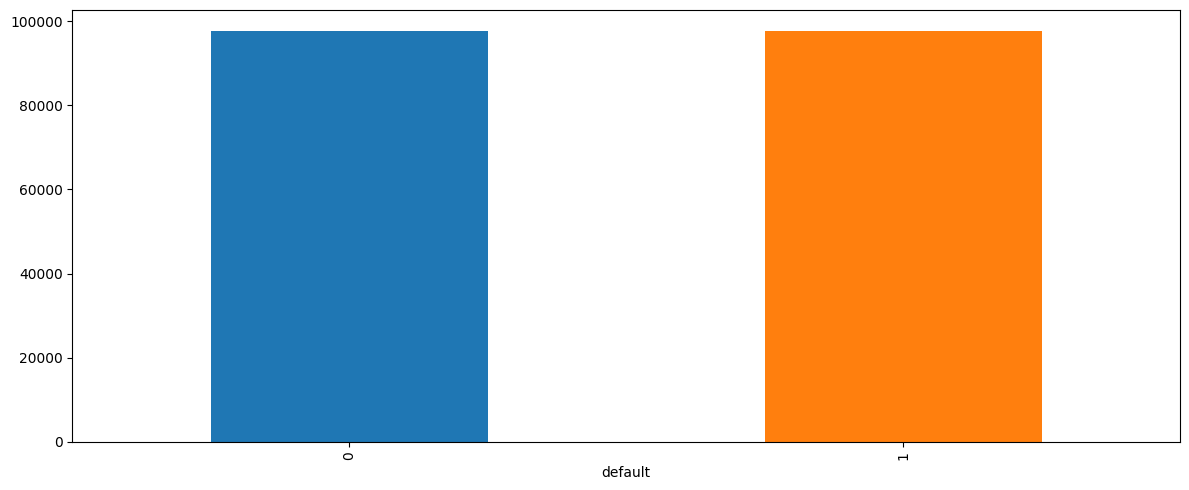

In [25]:
# Visualizando o resultado do resample
plt.rcParams['figure.figsize'] = [12.00, 5]
plt.rcParams['figure.autolayout'] = True
resposta_resample.value_counts().plot(kind='bar', color = ['#1F77B4', '#FF7F0E'])

## 4.3 Split do dataset entre treino e teste

In [26]:
X_treino, X_teste, Y_treino, Y_teste = train_test_split(preditoras_resample, resposta_resample, test_size = 0.3, random_state = 42)

## 4.4 Normalização dos dados

In [27]:
# Utilizando o MinMaxScaler para realizar a normalização dos dados
mms = MinMaxScaler()
X_train = mms.fit_transform(X_treino)
X_test = mms.fit_transform(X_teste)

# 5.0 Machine Learning Modeling

In [28]:
# Criando o classificador com Random Forest
clf = RandomForestClassifier(n_estimators = 300)

# Treino
clf = clf.fit(X_train, Y_treino)

In [29]:
# verificando a acurácia do modelo
scores = clf.score(X_test, Y_teste)
scores

0.9054521888909732

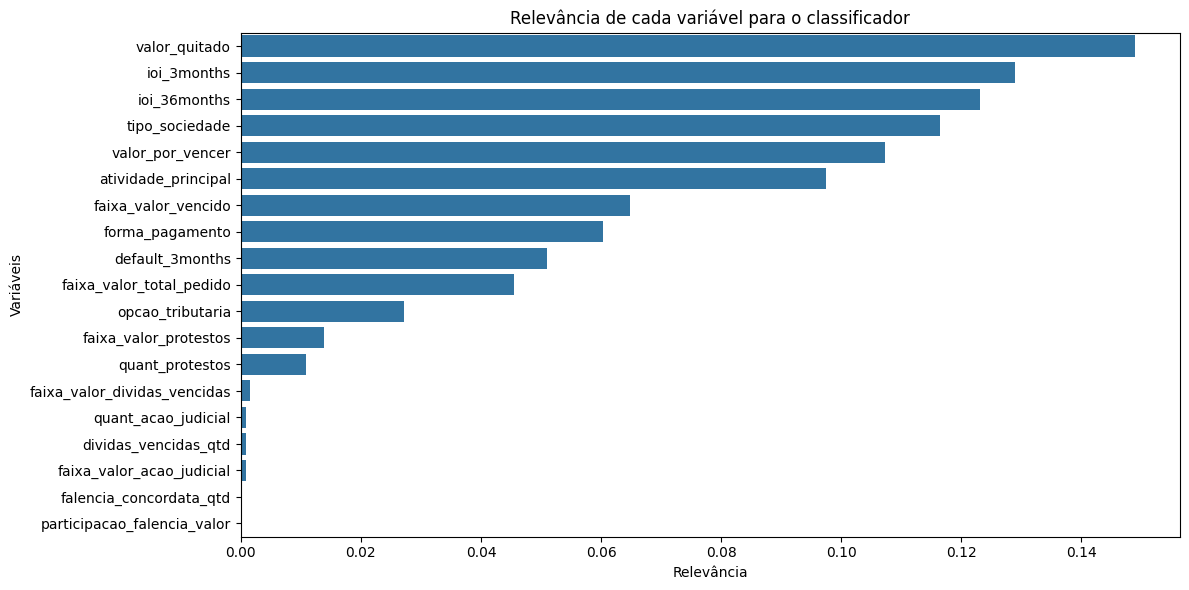

In [30]:
# Verificando as variáveis relevantes

features_relevantes = pd.Series(data=clf.feature_importances_, index=preditoras_resample.columns)
features_relevantes = features_relevantes.sort_values(ascending=False)

# Plotar o gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x=features_relevantes, y=features_relevantes.index, orient='h')
plt.title('Relevância de cada variável para o classificador')
plt.xlabel('Relevância')
plt.ylabel('Variáveis')
plt.show()

# 6.0 Interpretação do erro

## 6.1 Criando as colunas 'previsão_calote', 'probs_0' e 'probs_1'
- Colunas probs_0 e probs_1 medem a porcentagem de cada das probabilidades e a previsão_calote é o resultado da previsão

In [34]:
# Utilizando MMS
normalizador = MinMaxScaler()
df_normalizado = normalizador.fit_transform(preditoras)

probs = clf.predict_proba(df_normalizado)

# Criar colunas separadas para cada classe nas probabilidades
classes = clf.classes_
for i, classe in enumerate(classes):
    df2[f'probs_{classe}'] = probs[:, i]

# Fazer previsões usando predict (classes)
previsoes = clf.predict(df_normalizado)

# Adicionar coluna para as previsões
df2['previsao_calote'] = previsoes

## 6.2 Curva ROC
- Utilizando a métrica Curva ROC para medir a acúracia da previsão em relação a variável resposta 'default'

In [41]:
y_true = df2['default']
auc_roc = roc_auc_score(y_true, probs[:, 1])
print(f'AUC ROC: {auc_roc:.2f}')

AUC ROC: 0.99
